# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [2]:
#Import all the required libraries
import os
from os import listdir
import numpy as np
from numpy import asarray
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [3]:
# Loading and Resizing the images while reloading
def load_images(path, size = (256,256)):
    data_list = list()
    
    for filename in listdir(path):
        pixels = load_img(path+filename, target_size = size)
        # Converting it into numpy array
        pixels = img_to_array(pixels)
        # Store the data
        data_list.append(pixels)
    return asarray(data_list)

In [4]:
# Loading tr1
tr1_data = tf.image.rgb_to_grayscale(load_images('dataset/Tr1/TrainT1/'))
tr1 = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr1

<TensorSliceDataset shapes: (256, 256, 1), types: tf.float32>

In [5]:
# Loading tr2
tr2_data = tf.image.rgb_to_grayscale(load_images('dataset/Tr2/TrainT2/'))
tr2 = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))
tr2

<TensorSliceDataset shapes: (256, 256, 1), types: tf.float32>

## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [6]:
Buffer_Size = 1000
Batch_Size = 1

In [7]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image/127.5)-1
    return image

In [8]:
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [9]:
# process both classes of MRI images
autotune = tf.data.experimental.AUTOTUNE
tr1 = tr1.map(preprocess_image_train, num_parallel_calls=autotune).cache().shuffle(Buffer_Size).batch(Batch_Size)
tr2 = tr2.map(preprocess_image_train, num_parallel_calls=autotune).cache().shuffle(Buffer_Size).batch(Batch_Size)

In [10]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

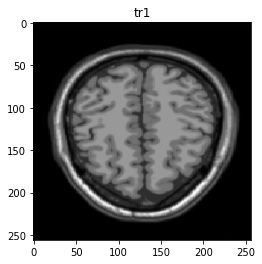

In [11]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

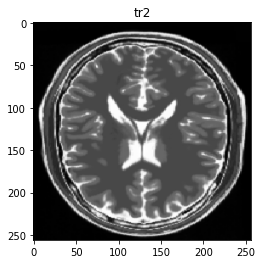

In [12]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [13]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [14]:
def unet_generator():
    down_stack = [
        downsample(64,4,apply_norm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
    ]
    up_stack = [
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4),
        upsample(256,4),
        upsample(128,4),
        upsample(64,4)
    ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
generator_g = unet_generator() #initialise the generator
generator_f = unet_generator() #initialise the generator

In [16]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64,4,False)(x)  #write your code to downsample X
    down2 = downsample(128,4)(down1)   #write your code to downsample down1
    down3 = downsample(256,4)(down2)   #write your code to downsample down2
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs = inp, outputs = last)#create the model using input & output layer

In [17]:
discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

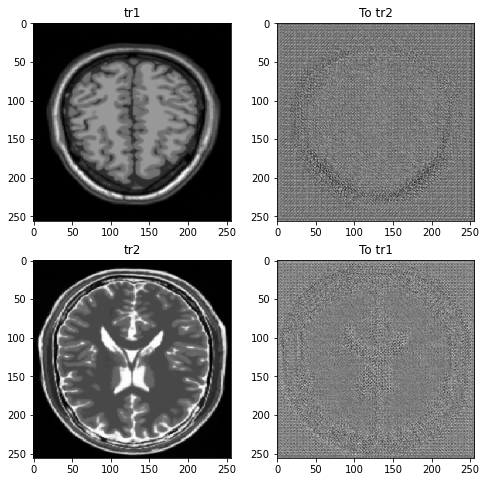

In [18]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [19]:
LAMBDA = 10

In [20]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)                  #write your code here
    generated_loss = loss_obj(tf.zeros_like(generated), generated)  #write your code here
    total_disc_loss = real_loss + generated_loss                    #write your code here
    return total_disc_loss * 0.5

In [22]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [23]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [24]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [25]:
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [26]:
EPOCHS = 50

In [27]:
checkpoint_path = './checkpoints'

ckpt = tf.compat.v1.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [28]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [29]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training = True)   #write your code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training = True) #write your code to generate images susiing Generator_f on fake_y
        
        fake_x = generator_f(real_y, training = True)   #write your code to generate images using Generator_f on real_y
        cycled_y = generator_g(real_y, training = True) #write your code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training = True)   #write your code to generate images using Generator_f on real_x
        same_y = generator_g(real_y, training = True)   #write your code to generate images using Generator_g on real_y
        
        disc_real_x = discriminator_x(real_x, training = True) #write your code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training = True) #write your code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x, training = True) #write your code to discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y, training = True) #write your code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y) #calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables) #write your code here
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables) #write your code here
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables) #write your code here
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables) #write your code here
    
    # Apply the gradients to the optimizer
    
    #write your code here
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


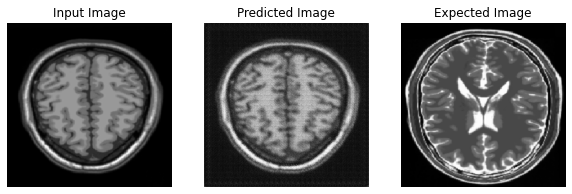

Saving checkpoint for epoch 0 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-1


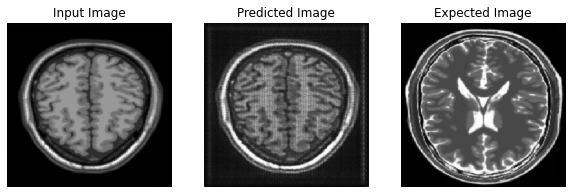

Saving checkpoint for epoch 1 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-2


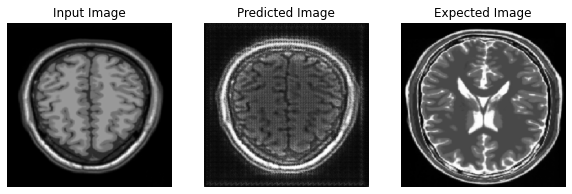

Saving checkpoint for epoch 2 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-3


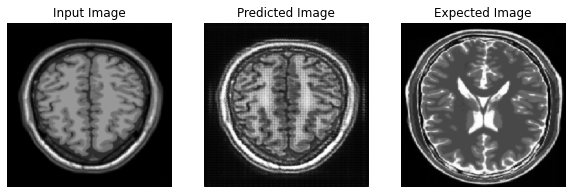

Saving checkpoint for epoch 3 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-4


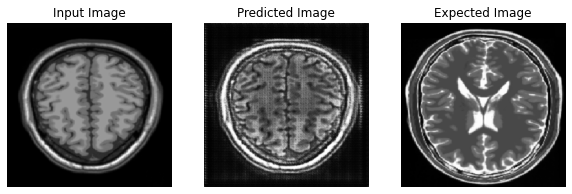

Saving checkpoint for epoch 4 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-5


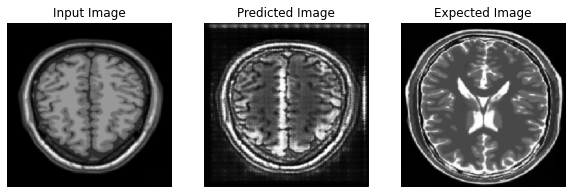

Saving checkpoint for epoch 5 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-6


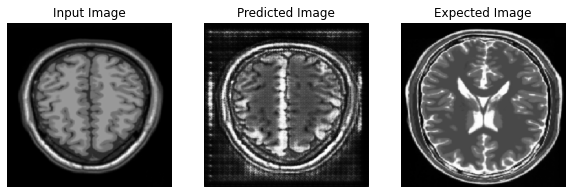

Saving checkpoint for epoch 6 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-7


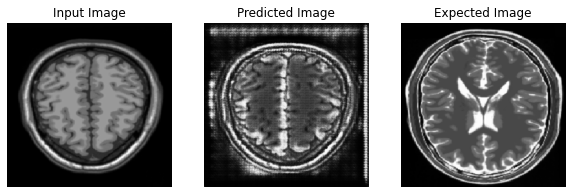

Saving checkpoint for epoch 7 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-8


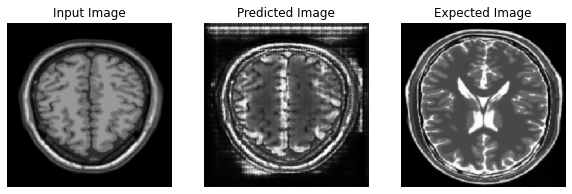

Saving checkpoint for epoch 8 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-9


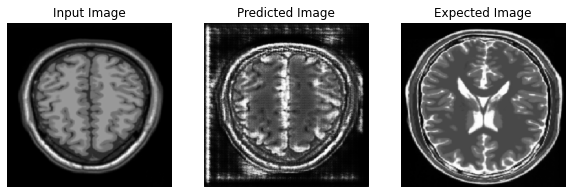

Saving checkpoint for epoch 9 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-10


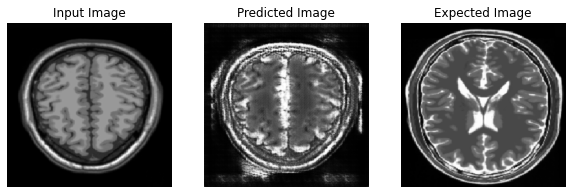

Saving checkpoint for epoch 10 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-11


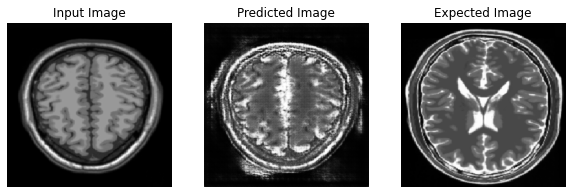

Saving checkpoint for epoch 11 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-12


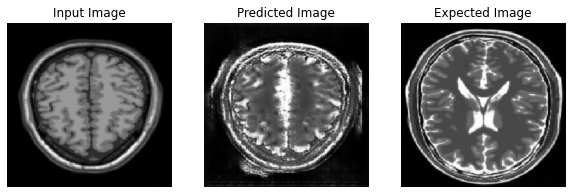

Saving checkpoint for epoch 12 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-13


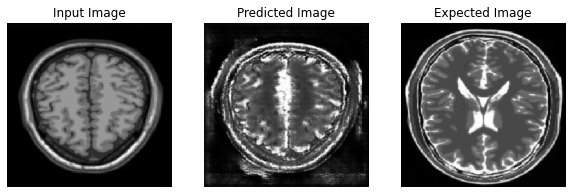

Saving checkpoint for epoch 13 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-14


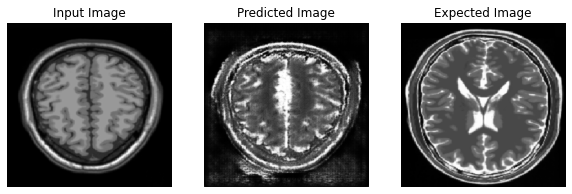

Saving checkpoint for epoch 14 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-15


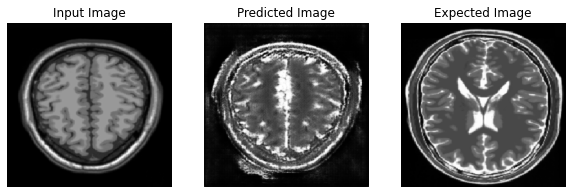

Saving checkpoint for epoch 15 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-16


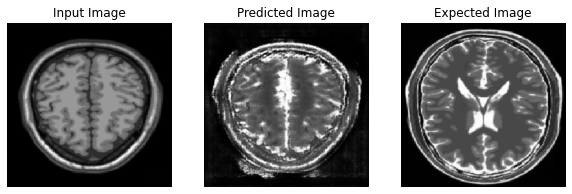

Saving checkpoint for epoch 16 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-17


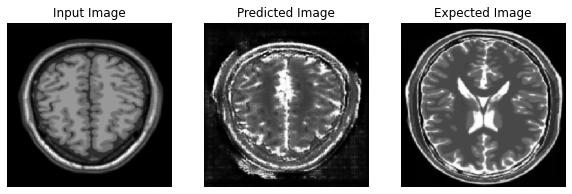

Saving checkpoint for epoch 17 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-18


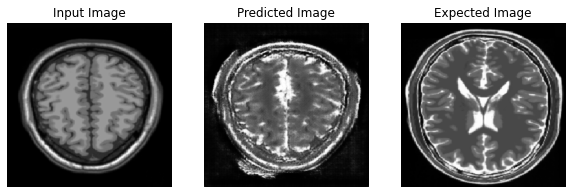

Saving checkpoint for epoch 18 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-19


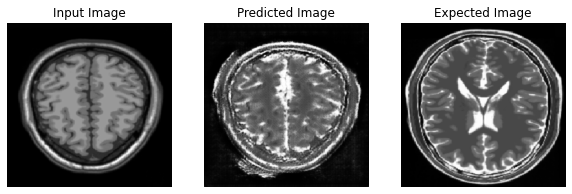

Saving checkpoint for epoch 19 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-20


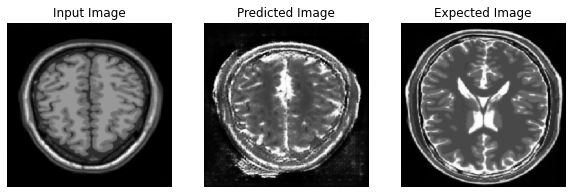

Saving checkpoint for epoch 20 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-21


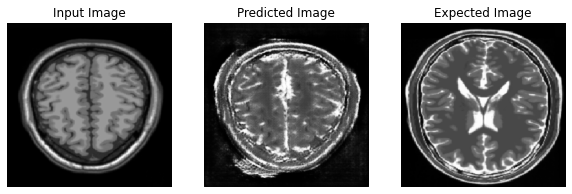

Saving checkpoint for epoch 21 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-22


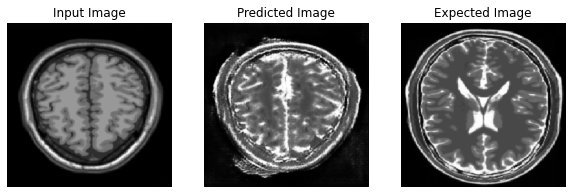

Saving checkpoint for epoch 22 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-23


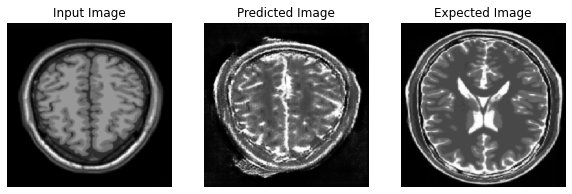

Saving checkpoint for epoch 23 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-24


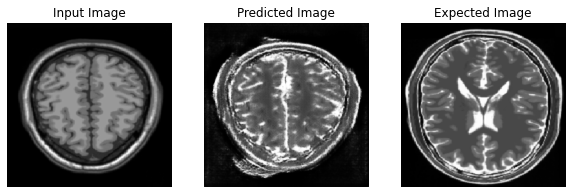

Saving checkpoint for epoch 24 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-25


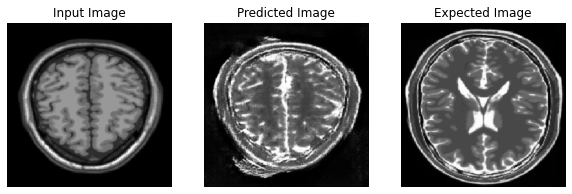

Saving checkpoint for epoch 25 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-26


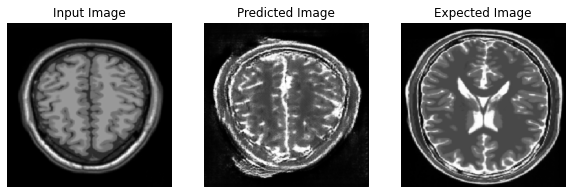

Saving checkpoint for epoch 26 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-27


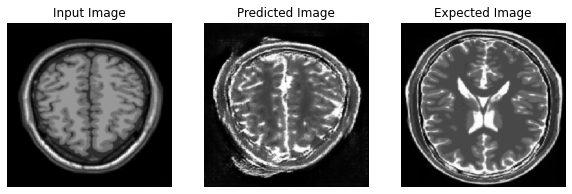

Saving checkpoint for epoch 27 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-28


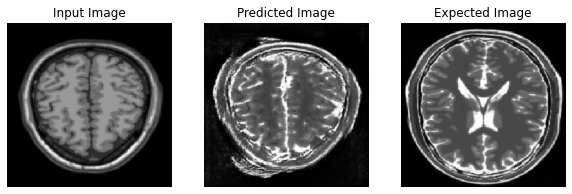

Saving checkpoint for epoch 28 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-29


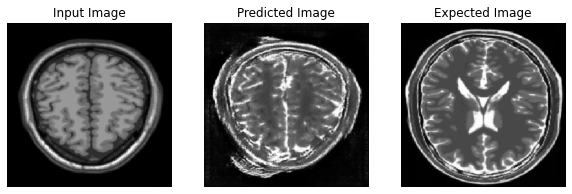

Saving checkpoint for epoch 29 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-30


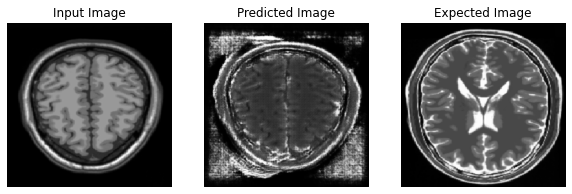

Saving checkpoint for epoch 30 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-31


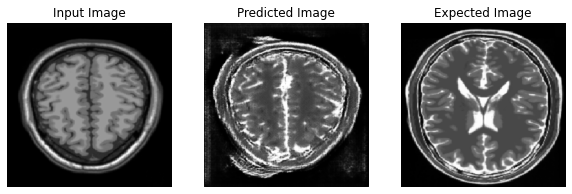

Saving checkpoint for epoch 31 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-32


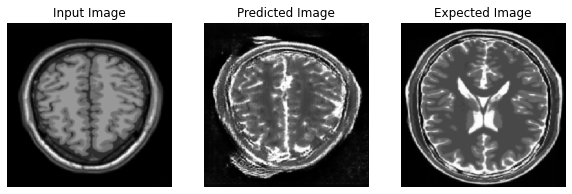

Saving checkpoint for epoch 32 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-33


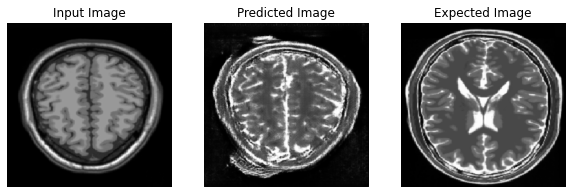

Saving checkpoint for epoch 33 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-34


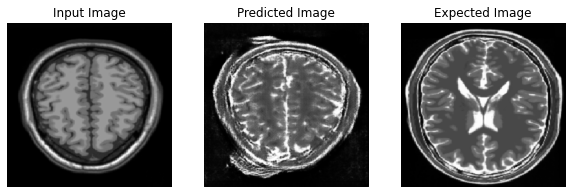

Saving checkpoint for epoch 34 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-35


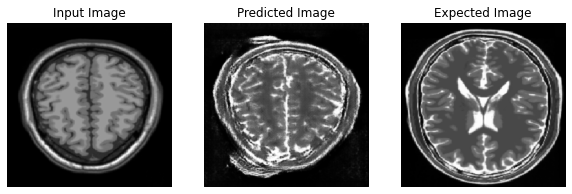

Saving checkpoint for epoch 35 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-36


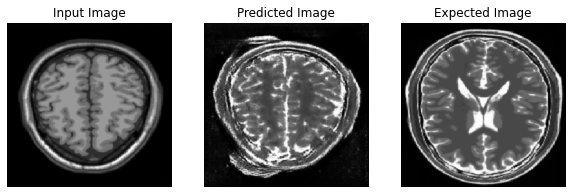

Saving checkpoint for epoch 36 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-37


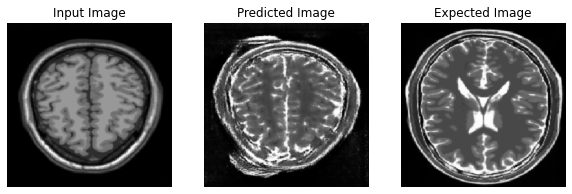

Saving checkpoint for epoch 37 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-38


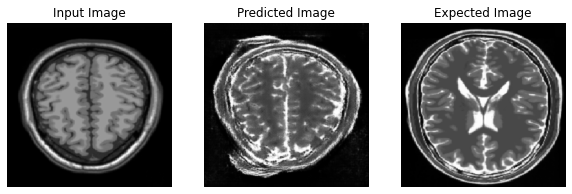

Saving checkpoint for epoch 38 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-39


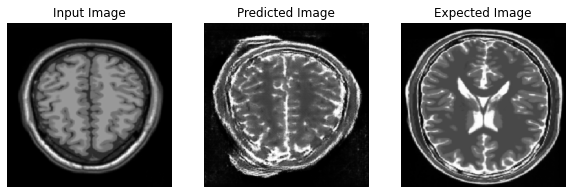

Saving checkpoint for epoch 39 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-40


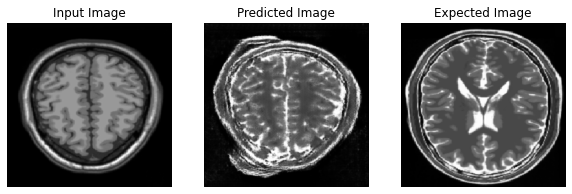

Saving checkpoint for epoch 40 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-41


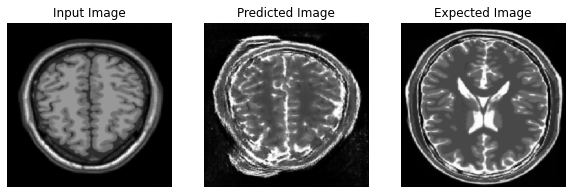

Saving checkpoint for epoch 41 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-42


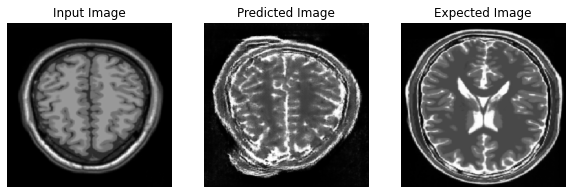

Saving checkpoint for epoch 42 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-43


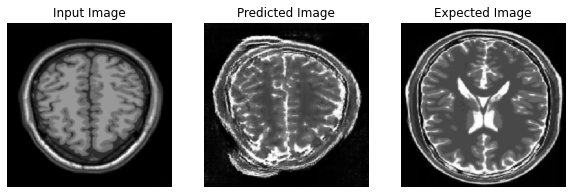

Saving checkpoint for epoch 43 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-44


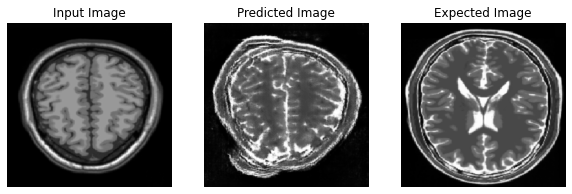

Saving checkpoint for epoch 44 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-45


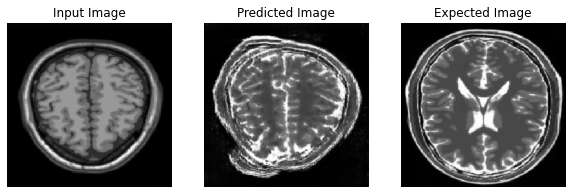

Saving checkpoint for epoch 45 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-46


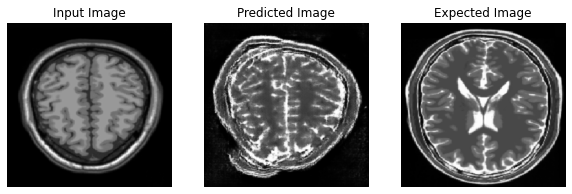

Saving checkpoint for epoch 46 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-47


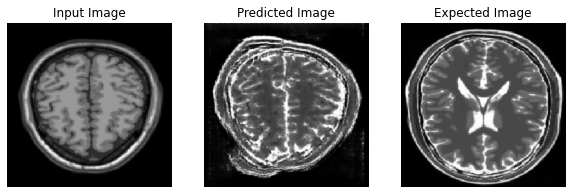

Saving checkpoint for epoch 47 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-48


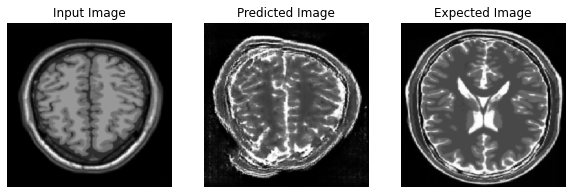

Saving checkpoint for epoch 48 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-49


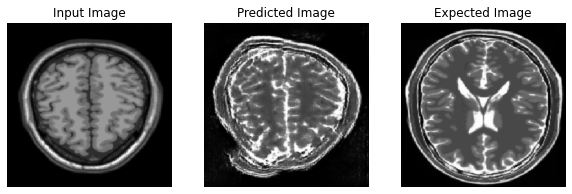

Saving checkpoint for epoch 49 at /content/drive/MyDrive/Colab Notebooks/Style Transfer Using Cycle GAN/checkpoints/ckpt-50


In [30]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

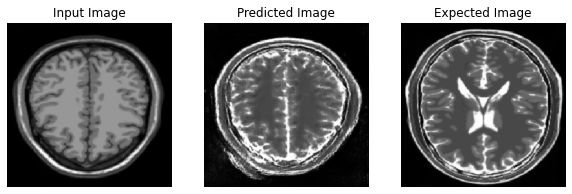

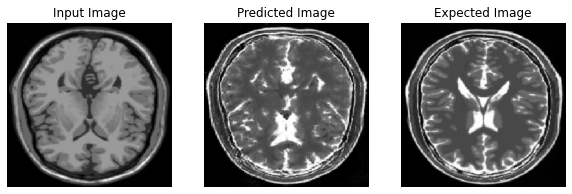

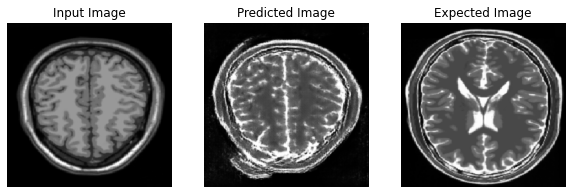

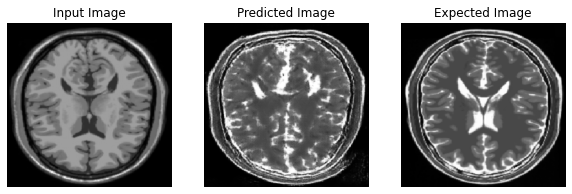

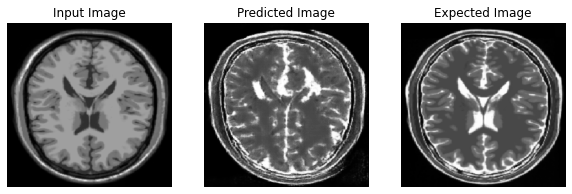

In [31]:
# Run the trained model on the test dataset
for inp in tr1.take(10):
    generate_images(generator_g, inp, sample_tr2)